# Evolución Temporal con spaCy
Este notebook analiza la evolución de la complejidad gramatical comparando diferentes períodos temporales

## Sección 1: Importar librerías y cargar datos

In [1]:
# 1. Importar librerías y cargar datos

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
from src.utils import path
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


In [2]:
# Cargar datos procesados
directorio_proyecto = path.obtener_ruta_local()
df = pd.read_csv(
    directorio_proyecto + '\\data\\results\\corpus_canciones_spacy.csv',
    delimiter=',',
    decimal=".",
    encoding='utf-8'
)

print(f"Dataset cargado: {df.shape[0]} canciones")
print(f"\nRango de años: {df['Periodo'].min():.0f} - {df['Periodo'].max():.0f}")
print(f"\nDistribución de canciones por período:")
print(df['Periodo'].value_counts().sort_index())

Dataset cargado: 5208 canciones

Rango de años: 1 - 2026

Distribución de canciones por período:
Periodo
1.0         3
1729.0      1
1787.0      1
1982.0      2
1988.0      2
1990.0      3
1993.0      1
1994.0      1
1996.0     13
1997.0     15
1998.0     19
1999.0     44
2000.0     55
2001.0     32
2002.0     86
2003.0     95
2004.0     44
2005.0     90
2006.0    152
2007.0    183
2008.0    222
2009.0    294
2010.0    337
2011.0    346
2012.0    242
2013.0    304
2014.0    282
2015.0    245
2016.0    360
2017.0    416
2018.0    372
2019.0    359
2020.0    440
2021.0     79
2022.0     23
2023.0     14
2024.0     18
2025.0     11
2026.0      2
Name: count, dtype: int64


In [3]:
df = df[df['Periodo'] >= 1980.0]

In [4]:
df.head()

,Artist,nombre_cancion,letra_cancion,Periodo,Genero,tokens,Etiquetado_POS,StopWords,Minusculas,Lematizado
0,Ariana Grande,"​thank u, next",thought i'd end up with sean but he wasn't a m...,2018.0,pop,"['thought', 'i', ""'d"", 'end', 'up', 'with', 's...","[('thought', 'VERB'), ('i', 'PRON'), (""'d"", 'A...","[('thought', 'VERB'), ('end', 'VERB'), ('sean'...","[('thought', 'VERB'), ('end', 'VERB'), ('sean'...","[('thought', 'NOUN'), ('end', 'PROPN'), ('sean..."
1,Ariana Grande,7 rings,yeah breakfast at tiffany's and bottles of bub...,2019.0,pop,"['yeah', 'breakfast', 'at', 'tiffany', ""'s"", '...","[('yeah', 'INTJ'), ('breakfast', 'NOUN'), ('at...","[('yeah', 'INTJ'), ('breakfast', 'NOUN'), ('ti...","[('yeah', 'INTJ'), ('breakfast', 'NOUN'), ('ti...","[('yeah', 'INTJ'), ('breakfast', 'NOUN'), ('ti..."
2,Ariana Grande,​God is a woman,you you love it how i move you you love it how...,2018.0,pop,"['you', 'you', 'love', 'it', 'how', 'i', 'move...","[('you', 'PRON'), ('you', 'PRON'), ('love', 'V...","[('love', 'VERB'), ('love', 'VERB'), ('touch',...","[('love', 'VERB'), ('love', 'VERB'), ('touch',...","[('love', 'NOUN'), ('love', 'NOUN'), ('touch',..."
3,Ariana Grande,Side To Side,ariana grande nicki minaj i've been here all ...,2016.0,pop,"['ariana', 'grande', ' ', 'nicki', 'minaj', 'i...","[('ariana', 'PROPN'), ('grande', 'VERB'), (' ...","[('ariana', 'PROPN'), ('grande', 'VERB'), (' ...","[('ariana', 'PROPN'), ('grande', 'VERB'), (' ...","[('ariana', 'PROPN'), ('grande', 'VERB'), (' ..."
4,Ariana Grande,​​no tears left to cry,right now i'm in a state of mind i wanna be in...,2018.0,pop,"['right', 'now', 'i', ""'m"", 'in', 'a', 'state'...","[('right', 'ADV'), ('now', 'ADV'), ('i', 'PRON...","[('right', 'ADV'), (""'"", 'VERB'), ('m', 'VERB'...","[('right', 'ADV'), (""'"", 'VERB'), ('m', 'VERB'...","[('right', 'INTJ'), (""'"", 'PUNCT'), ('m', 'PRO..."


## Sección 2: Funciones auxiliares para análisis temporal

In [5]:
# 2. Funciones auxiliares para análisis temporal

def extraer_pos_tags(pos_string):
    """Extrae las etiquetas POS de una cadena de texto."""
    if pd.isna(pos_string):
        return []
    tags = re.findall(r",\s*'([^']+)'\)", str(pos_string))
    return tags

def extraer_palabras(tokens_string):
    """Extrae palabras de una lista de tokens."""
    if pd.isna(tokens_string):
        return []
    palabras = re.findall(r"'([^']+)'", str(tokens_string))
    return palabras

def calcular_complejidad_gramatical(pos_list):
    """
    Calcula un índice de complejidad gramatical.
    Complejidad = (adjetivos + adverbios + subordinantes) / total tokens
    """
    if not pos_list or len(pos_list) == 0:
        return 0

    # Palabras que indican complejidad
    complejas = sum(1 for tag in pos_list if tag in ['ADJ', 'ADV', 'SCONJ', 'CCONJ'])
    total = len(pos_list)

    return complejas / total if total > 0 else 0

def calcular_diversidad_lexica(palabras):
    """
    Calcula la diversidad léxica (Type-Token Ratio).
    """
    if not palabras or len(palabras) == 0:
        return 0
    types = len(set(palabras))
    tokens = len(palabras)
    return types / tokens if tokens > 0 else 0

def calcular_longitud_promedio_oracion(pos_list):
    """
    Estima la longitud promedio de oraciones contando puntuaciones.
    """
    if not pos_list or len(pos_list) == 0:
        return 0

    # Contar marcadores de fin de oración
    puntuaciones = sum(1 for tag in pos_list if tag == 'PUNCT')

    if puntuaciones == 0:
        return len(pos_list)

    return len(pos_list) / puntuaciones

def categorizar_periodo(year):
    """
    Categoriza años en décadas/períodos.
    """
    if pd.isna(year):
        return 'Desconocido'

    year = int(year)

    if year < 1990:
        return 'Pre-90s'
    elif 1990 <= year < 2000:
        return '90s'
    elif 2000 <= year < 2010:
        return '2000s'
    elif 2010 <= year < 2020:
        return '2010s'
    else:
        return '2020s'

print("✓ Funciones auxiliares definidas")

✓ Funciones auxiliares definidas


## Sección 3: Preprocesar y categorizar por períodos

In [6]:
# 3. Preprocesar y categorizar por períodos

print("Procesando datos temporales...")

# Extraer POS tags y palabras
df['pos_list'] = df['Lematizado'].apply(extraer_pos_tags)
df['palabras_list'] = df['tokens'].apply(extraer_palabras)

# Calcular métricas de complejidad
df['complejidad_gramatical'] = df['pos_list'].apply(calcular_complejidad_gramatical)
df['diversidad_lexica'] = df['palabras_list'].apply(calcular_diversidad_lexica)
df['longitud_oracion'] = df['pos_list'].apply(calcular_longitud_promedio_oracion)
df['num_tokens'] = df['pos_list'].apply(len)

# Categorizar por períodos
df['Periodo_Categoria'] = df['Periodo'].apply(categorizar_periodo)

print("✓ Métricas calculadas y períodos categorizados")

# Resumen por período
print("\nDistribución de canciones por período:")
print(df['Periodo_Categoria'].value_counts().sort_index())

# Verificar métricas
print("\nVerificación de métricas calculadas:")
print(df[['Periodo', 'Periodo_Categoria', 'complejidad_gramatical', 'diversidad_lexica', 'longitud_oracion']].head(10))

Procesando datos temporales...
✓ Métricas calculadas y períodos categorizados

Distribución de canciones por período:
Periodo_Categoria
2000s      1253
2010s      3263
2020s       587
90s          96
Pre-90s       4
Name: count, dtype: int64

Verificación de métricas calculadas:
   Periodo Periodo_Categoria  complejidad_gramatical  diversidad_lexica  \
0   2018.0             2010s                0.108000           0.208589   
1   2019.0             2010s                0.046610           0.185771   
2   2018.0             2010s                0.059172           0.160173   
3   2016.0             2010s                0.045872           0.187713   
4   2018.0             2010s                0.008451           0.139037   
5   2018.0             2010s                0.055276           0.188889   
6   2019.0             2010s                0.090164           0.219955   
7   2020.0             2020s                0.107143           0.192214   
8   2020.0             2020s                0

## Sección 4: Estadísticas descriptivas por período

In [7]:
# 4. Estadísticas descriptivas por período

print("="*80)
print("ESTADÍSTICAS DESCRIPTIVAS POR PERÍODO TEMPORAL")
print("="*80)

# Resumen de métricas por período
periodos_ordenados = ['Pre-90s', '90s', '2000s', '2010s', '2020s']
periodos_disponibles = [p for p in periodos_ordenados if p in df['Periodo_Categoria'].unique()]

metricas_por_periodo = df.groupby('Periodo_Categoria').agg({
    'nombre_cancion': 'count',
    'num_tokens': ['mean', 'median', 'std'],
    'complejidad_gramatical': ['mean', 'median', 'std'],
    'diversidad_lexica': ['mean', 'median', 'std'],
    'longitud_oracion': ['mean', 'median', 'std']
}).round(3)

metricas_por_periodo.columns = ['_'.join(col).strip() for col in metricas_por_periodo.columns.values]
metricas_por_periodo = metricas_por_periodo.rename(columns={'nombre_cancion_count': 'num_canciones'})

# Reordenar por período cronológico
metricas_por_periodo = metricas_por_periodo.reindex(periodos_disponibles)

print("\nMétricas por período temporal:")
print(metricas_por_periodo)
print("\n" + "="*80)

ESTADÍSTICAS DESCRIPTIVAS POR PERÍODO TEMPORAL

Métricas por período temporal:
                   num_canciones  num_tokens_mean  num_tokens_median  \
Periodo_Categoria                                                      
Pre-90s                        4          594.500              480.0   
90s                           96          283.896              316.5   
2000s                       1253          203.743              160.0   
2010s                       3263          210.692              174.0   
2020s                        587          172.015              154.0   

                   num_tokens_std  complejidad_gramatical_mean  \
Periodo_Categoria                                                
Pre-90s                   581.135                        0.123   
90s                       191.836                        0.128   
2000s                     150.741                        0.126   
2010s                     175.430                        0.119   
2020s               

## Sección 5: Análisis de tendencias temporales

In [8]:
# 5. Análisis de tendencias temporales

print("="*80)
print("ANÁLISIS DE TENDENCIAS TEMPORALES")
print("="*80)

# Calcular promedios anuales
tendencias_anuales = df.groupby('Periodo').agg({
    'complejidad_gramatical': 'mean',
    'diversidad_lexica': 'mean',
    'longitud_oracion': 'mean',
    'num_tokens': 'mean',
    'nombre_cancion': 'count'
}).round(3)

tendencias_anuales.columns = ['Complejidad', 'Diversidad', 'Long_Oracion', 'Tokens', 'N_Canciones']
tendencias_anuales = tendencias_anuales.sort_index()

print("\nTendencias anuales (primeros y últimos 5 años):")
print("\nPrimeros 5 años:")
print(tendencias_anuales.head())
print("\nÚltimos 5 años:")
print(tendencias_anuales.tail())

# Calcular correlaciones con el tiempo
años = tendencias_anuales.index.values
complejidad = tendencias_anuales['Complejidad'].values
diversidad = tendencias_anuales['Diversidad'].values
longitud = tendencias_anuales['Long_Oracion'].values

# Correlación de Pearson
corr_complejidad, p_complejidad = pearsonr(años, complejidad)
corr_diversidad, p_diversidad = pearsonr(años, diversidad)
corr_longitud, p_longitud = pearsonr(años, longitud)

print("\n" + "-"*80)
print("CORRELACIONES CON EL TIEMPO (Pearson):")
print("-"*80)
print(f"Complejidad Gramatical:  r={corr_complejidad:.4f}, p={p_complejidad:.6f}")
print(f"  → {'Tendencia creciente' if corr_complejidad > 0 else 'Tendencia decreciente'}")
print(f"\nDiversidad Léxica:       r={corr_diversidad:.4f}, p={p_diversidad:.6f}")
print(f"  → {'Tendencia creciente' if corr_diversidad > 0 else 'Tendencia decreciente'}")
print(f"\nLongitud de Oraciones:   r={corr_longitud:.4f}, p={p_longitud:.6f}")
print(f"  → {'Tendencia creciente' if corr_longitud > 0 else 'Tendencia decreciente'}")
print("="*80)

ANÁLISIS DE TENDENCIAS TEMPORALES

Tendencias anuales (primeros y últimos 5 años):

Primeros 5 años:
         Complejidad  Diversidad  Long_Oracion  Tokens  N_Canciones
Periodo                                                            
1982.0         0.100       0.343        75.343   781.5            2
1988.0         0.145       0.284        32.222   407.5            2
1990.0         0.165       0.188        28.236   566.0            3
1993.0         0.122       0.366        22.286   156.0            1
1994.0         0.000       1.000         3.000     3.0            1

Últimos 5 años:
         Complejidad  Diversidad  Long_Oracion   Tokens  N_Canciones
Periodo                                                             
2022.0         0.098       0.504        54.814  103.652           23
2023.0         0.122       0.719        13.100   29.929           14
2024.0         0.081       0.657        44.665   88.278           18
2025.0         0.121       0.631        30.903   68.091      

## Sección 6: Visualización de evolución temporal

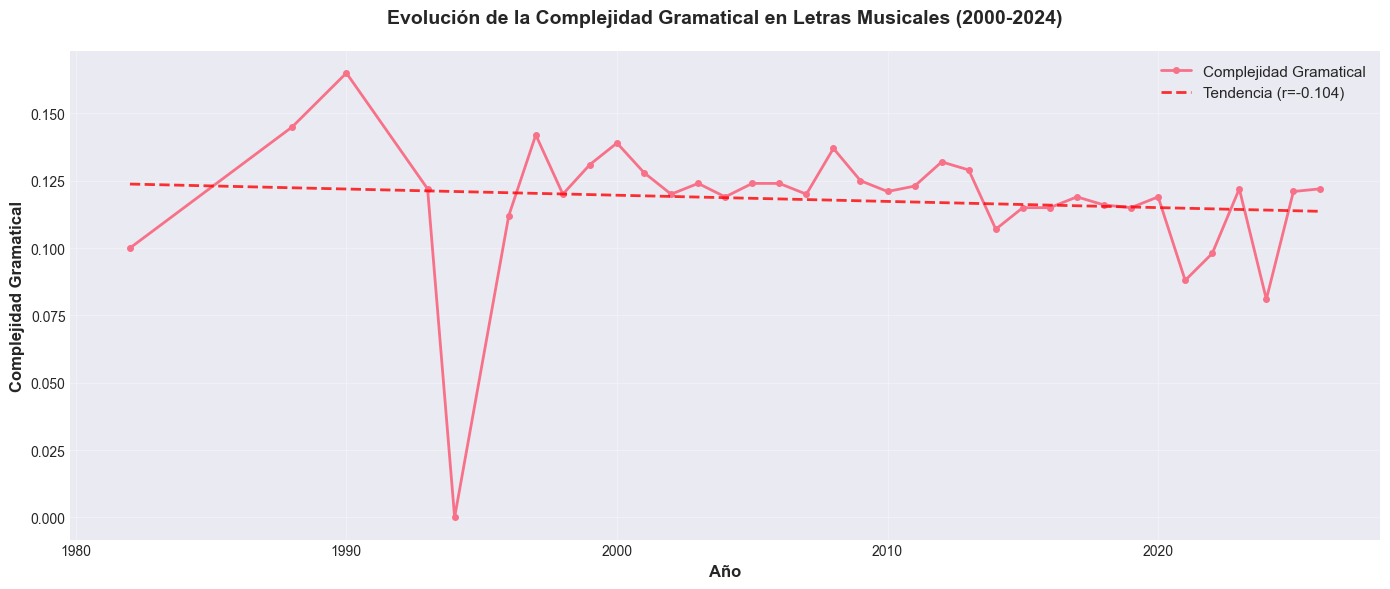

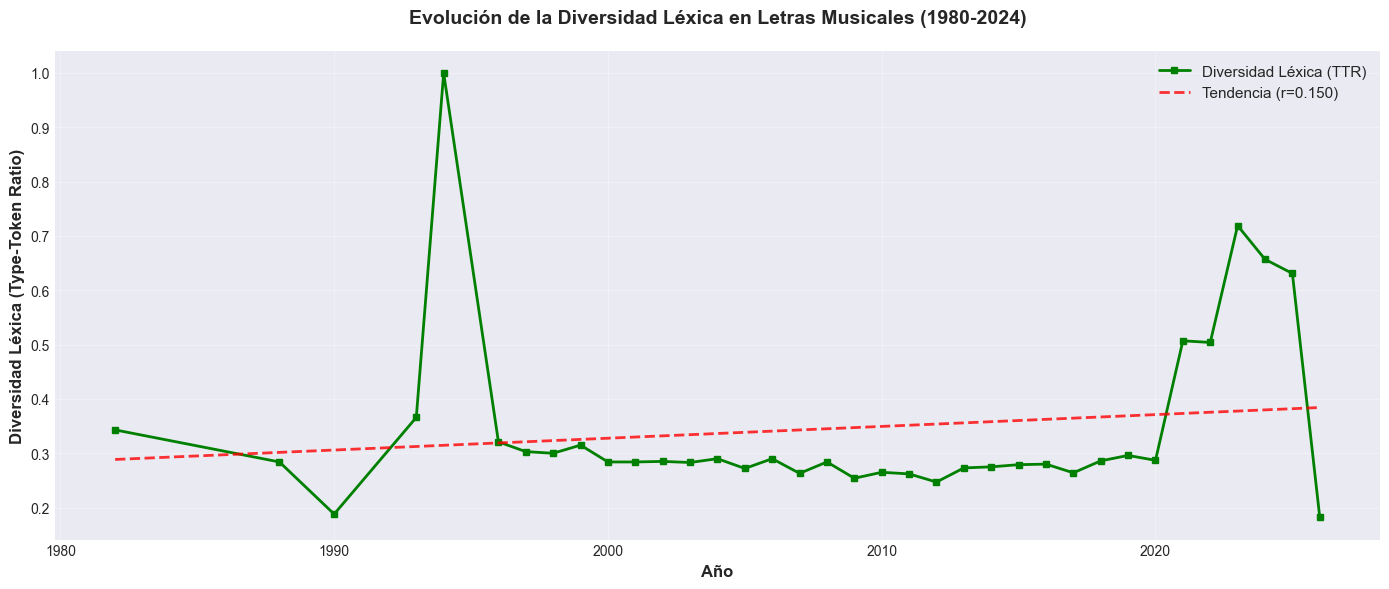

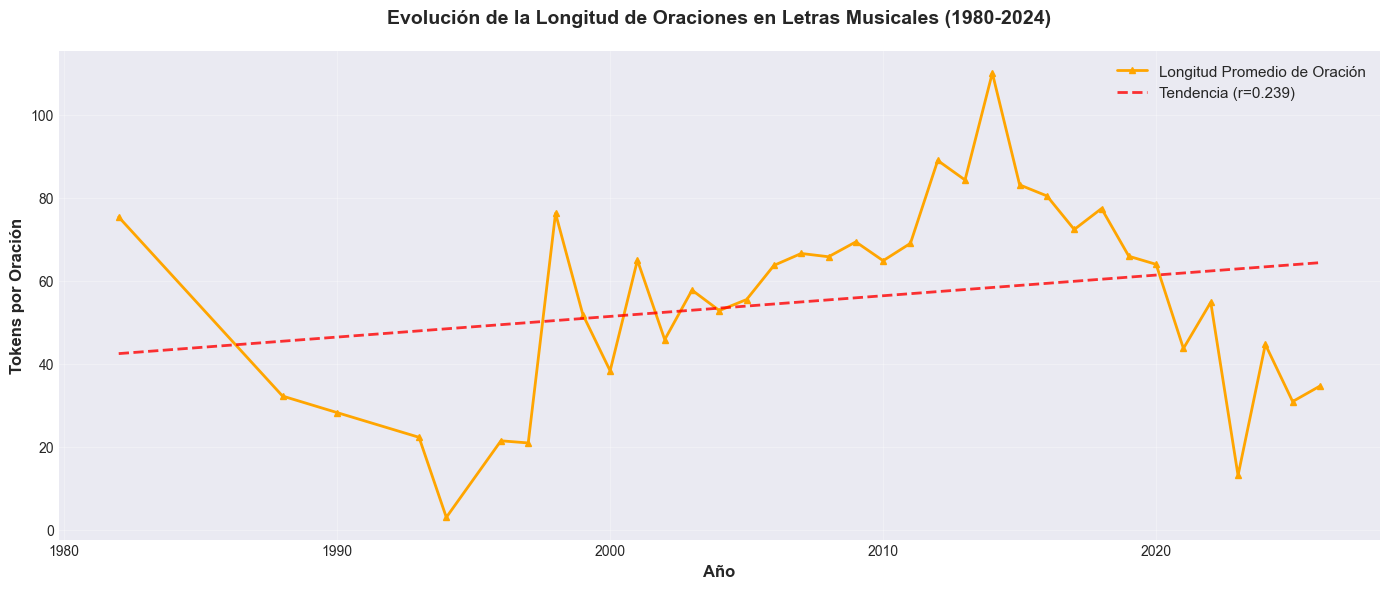

In [9]:
# 6. Visualización de evolución temporal

# Gráfico 1: Evolución de complejidad gramatical
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(tendencias_anuales.index, tendencias_anuales['Complejidad'],
        marker='o', linewidth=2, markersize=4, label='Complejidad Gramatical')

# Añadir línea de tendencia
z = np.polyfit(años, complejidad, 1)
p = np.poly1d(z)
ax.plot(años, p(años), "r--", alpha=0.8, linewidth=2, label=f'Tendencia (r={corr_complejidad:.3f})')

ax.set_xlabel('Año', fontsize=12, fontweight='bold')
ax.set_ylabel('Complejidad Gramatical', fontsize=12, fontweight='bold')
ax.set_title('Evolución de la Complejidad Gramatical en Letras Musicales (2000-2024)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico 2: Evolución de diversidad léxica
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(tendencias_anuales.index, tendencias_anuales['Diversidad'],
        marker='s', linewidth=2, markersize=4, color='green', label='Diversidad Léxica (TTR)')

# Añadir línea de tendencia
z = np.polyfit(años, diversidad, 1)
p = np.poly1d(z)
ax.plot(años, p(años), "r--", alpha=0.8, linewidth=2, label=f'Tendencia (r={corr_diversidad:.3f})')

ax.set_xlabel('Año', fontsize=12, fontweight='bold')
ax.set_ylabel('Diversidad Léxica (Type-Token Ratio)', fontsize=12, fontweight='bold')
ax.set_title('Evolución de la Diversidad Léxica en Letras Musicales (1980-2024)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico 3: Evolución de longitud de oraciones
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(tendencias_anuales.index, tendencias_anuales['Long_Oracion'],
        marker='^', linewidth=2, markersize=4, color='orange', label='Longitud Promedio de Oración')

# Añadir línea de tendencia
z = np.polyfit(años, longitud, 1)
p = np.poly1d(z)
ax.plot(años, p(años), "r--", alpha=0.8, linewidth=2, label=f'Tendencia (r={corr_longitud:.3f})')

ax.set_xlabel('Año', fontsize=12, fontweight='bold')
ax.set_ylabel('Tokens por Oración', fontsize=12, fontweight='bold')
ax.set_title('Evolución de la Longitud de Oraciones en Letras Musicales (1980-2024)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Sección 7: Comparación entre décadas

COMPARACIÓN ENTRE DÉCADAS

Estadísticas por década:
                   complejidad_gramatical_mean  complejidad_gramatical_std  \
Periodo_Categoria                                                            
Pre-90s                                  0.123                       0.029   
90s                                      0.128                       0.042   
2000s                                    0.126                       0.068   
2010s                                    0.119                       0.072   
2020s                                    0.113                       0.081   

                   diversidad_lexica_mean  diversidad_lexica_std  \
Periodo_Categoria                                                  
Pre-90s                             0.313                  0.100   
90s                                 0.314                  0.141   
2000s                               0.274                  0.133   
2010s                               0.273                  0.

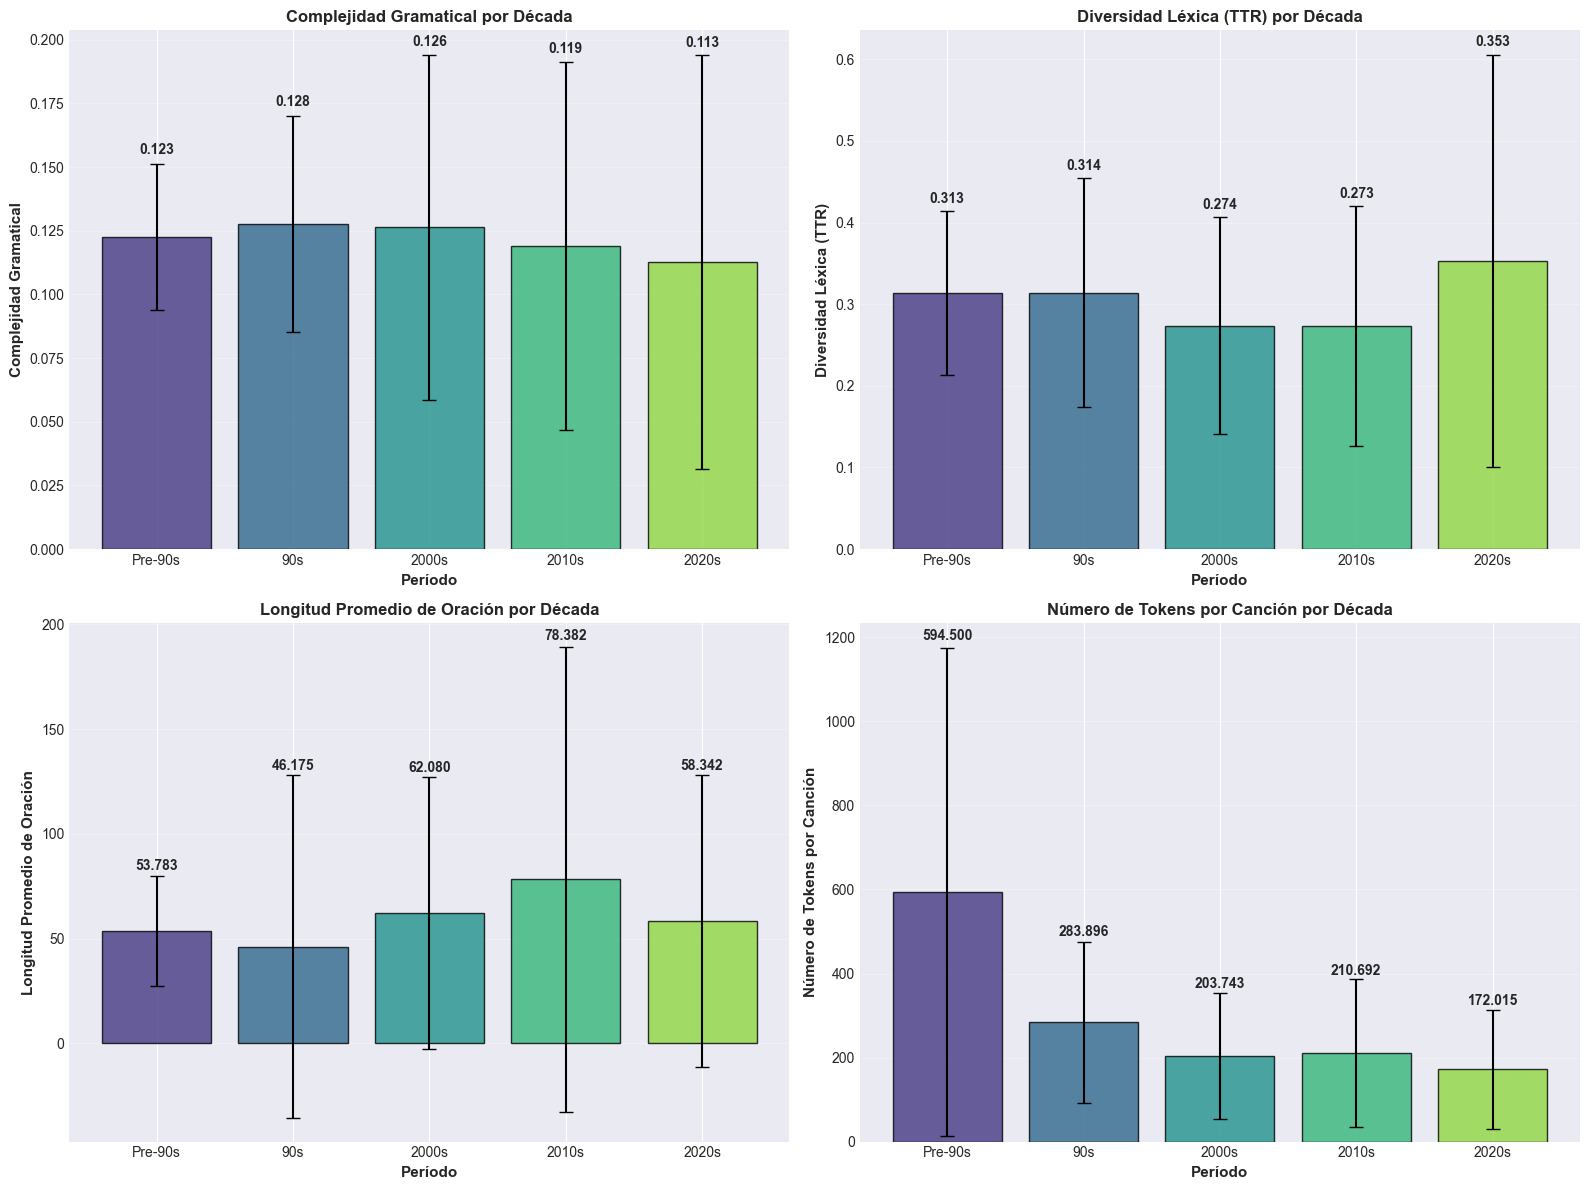

In [10]:
# 7. Comparación entre décadas

print("="*80)
print("COMPARACIÓN ENTRE DÉCADAS")
print("="*80)

# Estadísticas por década
decadas_stats = df.groupby('Periodo_Categoria').agg({
    'complejidad_gramatical': ['mean', 'std'],
    'diversidad_lexica': ['mean', 'std'],
    'longitud_oracion': ['mean', 'std'],
    'num_tokens': ['mean', 'std']
}).round(3)

decadas_stats.columns = ['_'.join(col).strip() for col in decadas_stats.columns.values]
decadas_stats = decadas_stats.reindex(periodos_disponibles)

print("\nEstadísticas por década:")
print(decadas_stats)

# Visualización: Comparación de métricas por década
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metricas = [
    ('complejidad_gramatical', 'Complejidad Gramatical'),
    ('diversidad_lexica', 'Diversidad Léxica (TTR)'),
    ('longitud_oracion', 'Longitud Promedio de Oración'),
    ('num_tokens', 'Número de Tokens por Canción')
]

for idx, (metrica, titulo) in enumerate(metricas):
    ax = axes[idx]

    # Preparar datos
    datos_plot = df.groupby('Periodo_Categoria')[metrica].mean().reindex(periodos_disponibles)
    errores = df.groupby('Periodo_Categoria')[metrica].std().reindex(periodos_disponibles)

    # Crear barras
    bars = ax.bar(range(len(periodos_disponibles)), datos_plot.values,
                  yerr=errores.values,
                  capsize=5,
                  color=sns.color_palette('viridis', len(periodos_disponibles)),
                  edgecolor='black',
                  alpha=0.8)

    # Añadir valores
    for i, (bar, valor) in enumerate(zip(bars, datos_plot.values)):
        ax.text(bar.get_x() + bar.get_width()/2,
                valor + (errores.values[i] if not np.isnan(errores.values[i]) else 0) + valor*0.02,
                f'{valor:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xticks(range(len(periodos_disponibles)))
    ax.set_xticklabels(periodos_disponibles, rotation=0)
    ax.set_xlabel('Período', fontsize=11, fontweight='bold')
    ax.set_ylabel(titulo, fontsize=11, fontweight='bold')
    ax.set_title(f'{titulo} por Década', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Sección 8: Análisis de distribuciones POS por período

In [11]:
# 8. Análisis de distribuciones POS por período

print("="*80)
print("EVOLUCIÓN DE DISTRIBUCIONES POS")
print("="*80)

# Crear diccionario para almacenar distribuciones por período
distribuciones_pos_temporal = {}

for periodo in periodos_disponibles:
    # Filtrar por período
    df_periodo = df[df['Periodo_Categoria'] == periodo]

    # Consolidar todos los POS tags del período
    all_pos = [tag for pos_list in df_periodo['pos_list'] for tag in pos_list]

    # Contar frecuencias
    pos_counts = Counter(all_pos)
    total = sum(pos_counts.values())

    # Calcular porcentajes
    pos_percentages = {tag: (count/total*100) for tag, count in pos_counts.items()}

    distribuciones_pos_temporal[periodo] = {
        'counts': pos_counts,
        'percentages': pos_percentages,
        'total_tokens': total,
        'num_canciones': len(df_periodo)
    }

    print(f"\n{periodo}:")
    print(f"  Total tokens: {total:,}")
    print(f"  Canciones: {len(df_periodo)}")
    print(f"  Top 5 POS tags: {pos_counts.most_common(5)}")

print("\n✓ Distribuciones POS por período calculadas")

EVOLUCIÓN DE DISTRIBUCIONES POS

Pre-90s:
  Total tokens: 2,378
  Canciones: 4
  Top 5 POS tags: [('NOUN', 688), ('PROPN', 570), ('VERB', 320), ('NUM', 203), ('ADJ', 200)]

90s:
  Total tokens: 27,254
  Canciones: 96
  Top 5 POS tags: [('NOUN', 9298), ('VERB', 5433), ('PROPN', 4357), ('ADJ', 2802), ('PUNCT', 1314)]

2000s:
  Total tokens: 255,290
  Canciones: 1253
  Top 5 POS tags: [('NOUN', 86617), ('VERB', 55154), ('PROPN', 32709), ('ADJ', 23271), ('INTJ', 10659)]

2010s:
  Total tokens: 687,489
  Canciones: 3263
  Top 5 POS tags: [('NOUN', 213577), ('VERB', 135253), ('PROPN', 118014), ('ADJ', 58089), ('INTJ', 34805)]

2020s:
  Total tokens: 100,973
  Canciones: 587
  Top 5 POS tags: [('NOUN', 30552), ('VERB', 19539), ('PROPN', 16494), ('ADJ', 8462), ('INTJ', 6046)]

✓ Distribuciones POS por período calculadas


## Sección 9: Visualización de categorías POS en el tiempo

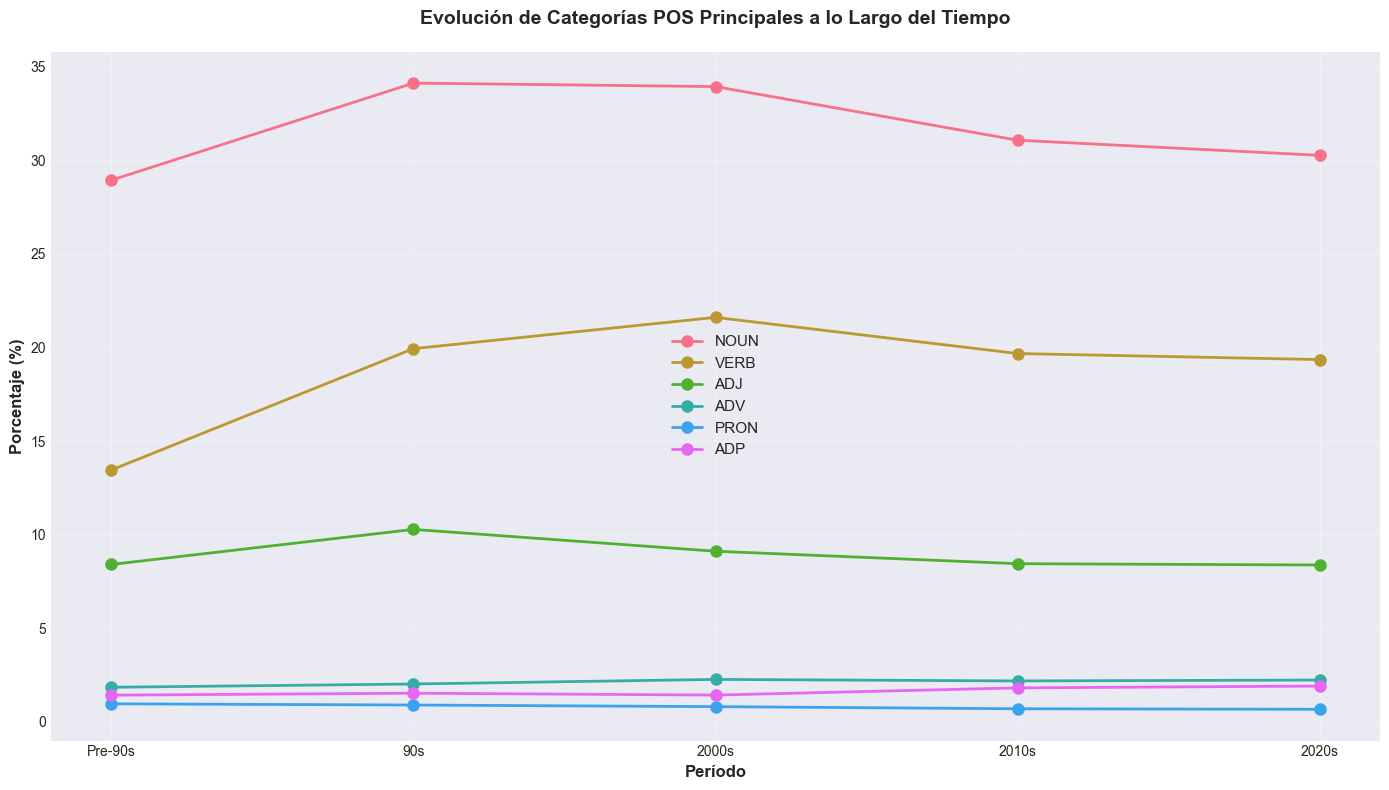

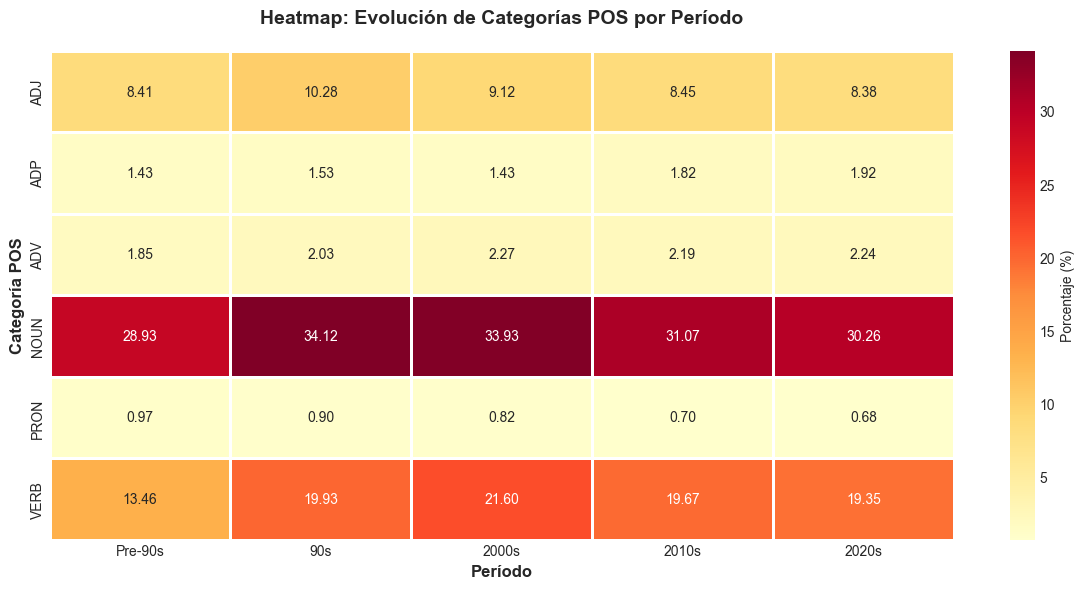

In [12]:
# 9. Visualización de categorías POS en el tiempo

# Seleccionar categorías principales
categorias_principales = ['NOUN', 'VERB', 'ADJ', 'ADV', 'PRON', 'ADP']

# Crear DataFrame para análisis temporal de POS
evolucion_pos = []

for periodo in periodos_disponibles:
    for categoria in categorias_principales:
        porcentaje = distribuciones_pos_temporal[periodo]['percentages'].get(categoria, 0)
        evolucion_pos.append({
            'Periodo': periodo,
            'Categoria': categoria,
            'Porcentaje': porcentaje
        })

df_evolucion_pos = pd.DataFrame(evolucion_pos)

# Visualización: Evolución de categorías POS
fig, ax = plt.subplots(figsize=(14, 8))

for categoria in categorias_principales:
    datos = df_evolucion_pos[df_evolucion_pos['Categoria'] == categoria]
    ax.plot(range(len(periodos_disponibles)), datos['Porcentaje'],
            marker='o', linewidth=2, markersize=8, label=categoria)

ax.set_xticks(range(len(periodos_disponibles)))
ax.set_xticklabels(periodos_disponibles, rotation=0)
ax.set_xlabel('Período', fontsize=12, fontweight='bold')
ax.set_ylabel('Porcentaje (%)', fontsize=12, fontweight='bold')
ax.set_title('Evolución de Categorías POS Principales a lo Largo del Tiempo',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Heatmap de evolución POS
tabla_evolucion = df_evolucion_pos.pivot(index='Categoria', columns='Periodo', values='Porcentaje')
tabla_evolucion = tabla_evolucion[periodos_disponibles]

fig, ax = plt.subplots(figsize=(12, 6))

sns.heatmap(tabla_evolucion, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'Porcentaje (%)'}, linewidths=1, ax=ax)

ax.set_xlabel('Período', fontsize=12, fontweight='bold')
ax.set_ylabel('Categoría POS', fontsize=12, fontweight='bold')
ax.set_title('Heatmap: Evolución de Categorías POS por Período',
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

## Sección 10: Pruebas estadísticas de cambio temporal

In [13]:
# 10. Pruebas estadísticas de cambio temporal

print("="*80)
print("PRUEBAS ESTADÍSTICAS DE CAMBIO TEMPORAL")
print("="*80)

# Test ANOVA para verificar diferencias entre períodos
from scipy.stats import f_oneway

# Preparar datos por período
datos_por_periodo = {}
for periodo in periodos_disponibles:
    datos_por_periodo[periodo] = df[df['Periodo_Categoria'] == periodo]

# ANOVA para complejidad gramatical
print("\n1. ANOVA - Complejidad Gramatical entre períodos:")
grupos_complejidad = [datos_por_periodo[p]['complejidad_gramatical'].dropna() for p in periodos_disponibles]
f_stat, p_value = f_oneway(*grupos_complejidad)
print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value: {p_value:.6f}")
print(f"   {'✓ Diferencias significativas' if p_value < 0.05 else '✗ No hay diferencias significativas'} (α=0.05)")

# ANOVA para diversidad léxica
print("\n2. ANOVA - Diversidad Léxica entre períodos:")
grupos_diversidad = [datos_por_periodo[p]['diversidad_lexica'].dropna() for p in periodos_disponibles]
f_stat, p_value = f_oneway(*grupos_diversidad)
print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value: {p_value:.6f}")
print(f"   {'✓ Diferencias significativas' if p_value < 0.05 else '✗ No hay diferencias significativas'} (α=0.05)")

# ANOVA para longitud de oraciones
print("\n3. ANOVA - Longitud de Oraciones entre períodos:")
grupos_longitud = [datos_por_periodo[p]['longitud_oracion'].dropna() for p in periodos_disponibles]
f_stat, p_value = f_oneway(*grupos_longitud)
print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value: {p_value:.6f}")
print(f"   {'✓ Diferencias significativas' if p_value < 0.05 else '✗ No hay diferencias significativas'} (α=0.05)")

print("\n" + "="*80)

PRUEBAS ESTADÍSTICAS DE CAMBIO TEMPORAL

1. ANOVA - Complejidad Gramatical entre períodos:
   F-statistic: 4.4241
   p-value: 0.001432
   ✓ Diferencias significativas (α=0.05)

2. ANOVA - Diversidad Léxica entre períodos:
   F-statistic: 33.1262
   p-value: 0.000000
   ✓ Diferencias significativas (α=0.05)

3. ANOVA - Longitud de Oraciones entre períodos:
   F-statistic: 11.4044
   p-value: 0.000000
   ✓ Diferencias significativas (α=0.05)



## Sección 11: Análisis de simplificación vs sofisticación

In [14]:
# 11. Análisis de simplificación vs sofisticación lingüística

print("="*80)
print("ANÁLISIS DE SIMPLIFICACIÓN VS SOFISTICACIÓN LINGÜÍSTICA")
print("="*80)

# Comparar primer y último período disponible
periodo_inicial = periodos_disponibles[0]
periodo_final = periodos_disponibles[-1]

print(f"\nComparando {periodo_inicial} vs {periodo_final}:")
print("-"*80)

# Calcular cambios porcentuales
metricas_inicial = df[df['Periodo_Categoria'] == periodo_inicial].agg({
    'complejidad_gramatical': 'mean',
    'diversidad_lexica': 'mean',
    'longitud_oracion': 'mean',
    'num_tokens': 'mean'
})

metricas_final = df[df['Periodo_Categoria'] == periodo_final].agg({
    'complejidad_gramatical': 'mean',
    'diversidad_lexica': 'mean',
    'longitud_oracion': 'mean',
    'num_tokens': 'mean'
})

cambios = ((metricas_final - metricas_inicial) / metricas_inicial * 100).round(2)

print(f"\nCambios porcentuales ({periodo_inicial} → {periodo_final}):")
print(f"  Complejidad Gramatical:    {cambios['complejidad_gramatical']:+.2f}%")
print(f"  Diversidad Léxica:         {cambios['diversidad_lexica']:+.2f}%")
print(f"  Longitud de Oraciones:     {cambios['longitud_oracion']:+.2f}%")
print(f"  Tokens por Canción:        {cambios['num_tokens']:+.2f}%")

# Interpretación
print("\n" + "-"*80)
print("INTERPRETACIÓN:")
print("-"*80)

tendencia_general = []

if cambios['complejidad_gramatical'] < -5:
    print("• Complejidad Gramatical: SIMPLIFICACIÓN significativa")
    tendencia_general.append('simplificación')
elif cambios['complejidad_gramatical'] > 5:
    print("• Complejidad Gramatical: SOFISTICACIÓN significativa")
    tendencia_general.append('sofisticación')
else:
    print("• Complejidad Gramatical: Cambio moderado")
    tendencia_general.append('estable')

if cambios['diversidad_lexica'] < -5:
    print("• Diversidad Léxica: REDUCCIÓN del vocabulario")
    tendencia_general.append('simplificación')
elif cambios['diversidad_lexica'] > 5:
    print("• Diversidad Léxica: AUMENTO del vocabulario")
    tendencia_general.append('sofisticación')
else:
    print("• Diversidad Léxica: Vocabulario estable")
    tendencia_general.append('estable')

if cambios['longitud_oracion'] < -10:
    print("• Longitud de Oraciones: ACORTAMIENTO significativo")
    tendencia_general.append('simplificación')
elif cambios['longitud_oracion'] > 10:
    print("• Longitud de Oraciones: ALARGAMIENTO significativo")
    tendencia_general.append('sofisticación')
else:
    print("• Longitud de Oraciones: Estructura similar")
    tendencia_general.append('estable')

# Conclusión general
print("\n" + "="*80)
conteo_tendencias = Counter(tendencia_general)
tendencia_dominante = conteo_tendencias.most_common(1)[0][0]

if tendencia_dominante == 'simplificación':
    print("CONCLUSIÓN: Las letras musicales muestran una TENDENCIA A LA SIMPLIFICACIÓN")
elif tendencia_dominante == 'sofisticación':
    print("CONCLUSIÓN: Las letras musicales muestran una TENDENCIA A LA SOFISTICACIÓN")
else:
    print("CONCLUSIÓN: Las letras musicales se mantienen RELATIVAMENTE ESTABLES")

print("="*80)

ANÁLISIS DE SIMPLIFICACIÓN VS SOFISTICACIÓN LINGÜÍSTICA

Comparando Pre-90s vs 2020s:
--------------------------------------------------------------------------------

Cambios porcentuales (Pre-90s → 2020s):
  Complejidad Gramatical:    -8.05%
  Diversidad Léxica:         +12.59%
  Longitud de Oraciones:     +8.48%
  Tokens por Canción:        -71.07%

--------------------------------------------------------------------------------
INTERPRETACIÓN:
--------------------------------------------------------------------------------
• Complejidad Gramatical: SIMPLIFICACIÓN significativa
• Diversidad Léxica: AUMENTO del vocabulario
• Longitud de Oraciones: Estructura similar

CONCLUSIÓN: Las letras musicales muestran una TENDENCIA A LA SIMPLIFICACIÓN


## Sección 12: Análisis por género a través del tiempo

EVOLUCIÓN TEMPORAL POR GÉNERO MUSICAL

Géneros disponibles: ['pop', 'alternative pop', 'K-pop', 'hip hop', 'alternative rock', 'dance-pop', 'r&b']
Top 3 géneros para análisis: ['pop', 'hip hop', 'alternative rock']

Muestra de datos:
             Genero  Periodo  Complejidad  Diversidad  N_Canciones
0               pop    2000s     0.130101    0.260899          723
1               pop    2010s     0.125742    0.258986         1889
2               pop    2020s     0.116956    0.368437          330
3           hip hop  Pre-90s     0.122582    0.313445            4
4           hip hop      90s     0.125254    0.323436           84
5           hip hop    2000s     0.117097    0.291831          390
6           hip hop    2010s     0.116973    0.274688          723
7           hip hop    2020s     0.117387    0.384472          114
8  alternative rock      90s     0.144524    0.250707           12
9  alternative rock    2000s     0.132833    0.290392          140


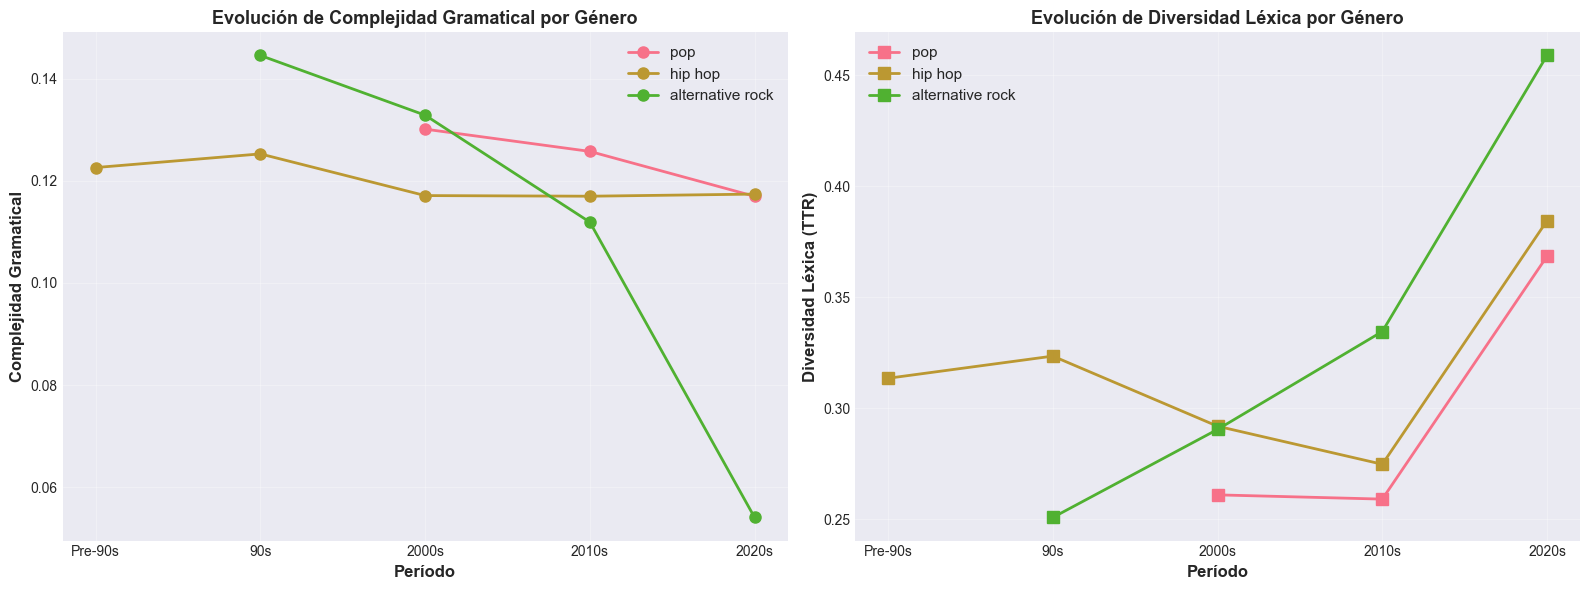


Cobertura de datos por género y período:
Periodo           Pre-90s  90s  2000s  2010s  2020s
Genero                                             
alternative rock        0   12    140    128      5
hip hop                 4   84    390    723    114
pop                     0    0    723   1889    330


In [15]:
# 12. Análisis por género a través del tiempo (CORREGIDO)

print("="*80)
print("EVOLUCIÓN TEMPORAL POR GÉNERO MUSICAL")
print("="*80)

# Verificar géneros disponibles
generos = df['Genero'].unique()
print(f"\nGéneros disponibles: {list(generos)}")

# Seleccionar top 3 géneros por número de canciones
top_generos = df['Genero'].value_counts().head(3).index.tolist()
print(f"Top 3 géneros para análisis: {top_generos}")

# Calcular métricas por género y período
evolucion_por_genero = []

for genero in top_generos:
    for periodo in periodos_disponibles:
        df_filtrado = df[(df['Genero'] == genero) & (df['Periodo_Categoria'] == periodo)]

        if len(df_filtrado) > 0:
            evolucion_por_genero.append({
                'Genero': genero,
                'Periodo': periodo,
                'Complejidad': df_filtrado['complejidad_gramatical'].mean(),
                'Diversidad': df_filtrado['diversidad_lexica'].mean(),
                'N_Canciones': len(df_filtrado)
            })

df_evolucion_genero = pd.DataFrame(evolucion_por_genero)

print("\nMuestra de datos:")
print(df_evolucion_genero.head(10))

# Visualización: Complejidad por género en el tiempo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Complejidad Gramatical
ax1 = axes[0]
for genero in top_generos:
    datos = df_evolucion_genero[df_evolucion_genero['Genero'] == genero]

    # Crear índices solo para los períodos que tiene este género
    periodos_genero = datos['Periodo'].values
    indices_x = [periodos_disponibles.index(p) for p in periodos_genero]

    ax1.plot(indices_x, datos['Complejidad'].values,
            marker='o', linewidth=2, markersize=8, label=genero)

ax1.set_xticks(range(len(periodos_disponibles)))
ax1.set_xticklabels(periodos_disponibles, rotation=0)
ax1.set_xlabel('Período', fontsize=12, fontweight='bold')
ax1.set_ylabel('Complejidad Gramatical', fontsize=12, fontweight='bold')
ax1.set_title('Evolución de Complejidad Gramatical por Género',
             fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Diversidad Léxica
ax2 = axes[1]
for genero in top_generos:
    datos = df_evolucion_genero[df_evolucion_genero['Genero'] == genero]

    # Crear índices solo para los períodos que tiene este género
    periodos_genero = datos['Periodo'].values
    indices_x = [periodos_disponibles.index(p) for p in periodos_genero]

    ax2.plot(indices_x, datos['Diversidad'].values,
            marker='s', linewidth=2, markersize=8, label=genero)

ax2.set_xticks(range(len(periodos_disponibles)))
ax2.set_xticklabels(periodos_disponibles, rotation=0)
ax2.set_xlabel('Período', fontsize=12, fontweight='bold')
ax2.set_ylabel('Diversidad Léxica (TTR)', fontsize=12, fontweight='bold')
ax2.set_title('Evolución de Diversidad Léxica por Género',
             fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla de cobertura de datos
print("\nCobertura de datos por género y período:")
tabla_cobertura = df_evolucion_genero.pivot(index='Genero', columns='Periodo', values='N_Canciones')
tabla_cobertura = tabla_cobertura[periodos_disponibles]
print(tabla_cobertura.fillna(0).astype(int))

## Sección 13: Resumen ejecutivo y conclusiones

In [16]:
# 13. Resumen ejecutivo y conclusiones

print("\n" + "="*80)
print("RESUMEN EJECUTIVO - EVOLUCIÓN TEMPORAL DE COMPLEJIDAD GRAMATICAL")
print("="*80)

# Tabla resumen final por período
resumen_final = df.groupby('Periodo_Categoria').agg({
    'nombre_cancion': 'count',
    'num_tokens': 'mean',
    'complejidad_gramatical': 'mean',
    'diversidad_lexica': 'mean',
    'longitud_oracion': 'mean'
}).round(3)

resumen_final.columns = ['N_Canciones', 'Tokens_Medio', 'Complejidad', 'Diversidad', 'Long_Oracion']
resumen_final = resumen_final.reindex(periodos_disponibles)

print("\nTABLA RESUMEN POR PERÍODO:")
print("-"*80)
print(resumen_final)

# Identificar tendencias principales
print("\n" + "="*80)
print("TENDENCIAS IDENTIFICADAS:")
print("="*80)

# Tendencia de complejidad
valores_complejidad = resumen_final['Complejidad'].values
if len(valores_complejidad) >= 2:
    cambio_complejidad = valores_complejidad[-1] - valores_complejidad[0]
    cambio_pct_complejidad = (cambio_complejidad / valores_complejidad[0] * 100)

    print(f"\n1. COMPLEJIDAD GRAMATICAL:")
    print(f"   Valor inicial ({periodos_disponibles[0]}): {valores_complejidad[0]:.4f}")
    print(f"   Valor final ({periodos_disponibles[-1]}): {valores_complejidad[-1]:.4f}")
    print(f"   Cambio: {cambio_pct_complejidad:+.2f}%")

    if cambio_pct_complejidad < -5:
        print(f"   → SIMPLIFICACIÓN: Las letras son menos complejas gramaticalmente")
    elif cambio_pct_complejidad > 5:
        print(f"   → SOFISTICACIÓN: Las letras son más complejas gramaticalmente")
    else:
        print(f"   → ESTABILIDAD: La complejidad se mantiene relativamente estable")

# Tendencia de diversidad
valores_diversidad = resumen_final['Diversidad'].values
if len(valores_diversidad) >= 2:
    cambio_diversidad = valores_diversidad[-1] - valores_diversidad[0]
    cambio_pct_diversidad = (cambio_diversidad / valores_diversidad[0] * 100)

    print(f"\n2. DIVERSIDAD LÉXICA:")
    print(f"   Valor inicial ({periodos_disponibles[0]}): {valores_diversidad[0]:.4f}")
    print(f"   Valor final ({periodos_disponibles[-1]}): {valores_diversidad[-1]:.4f}")
    print(f"   Cambio: {cambio_pct_diversidad:+.2f}%")

    if cambio_pct_diversidad < -5:
        print(f"   → REDUCCIÓN: Menor variedad de vocabulario")
    elif cambio_pct_diversidad > 5:
        print(f"   → EXPANSIÓN: Mayor variedad de vocabulario")
    else:
        print(f"   → ESTABILIDAD: El vocabulario se mantiene similar")

# Tendencia de longitud de oraciones
valores_longitud = resumen_final['Long_Oracion'].values
if len(valores_longitud) >= 2:
    cambio_longitud = valores_longitud[-1] - valores_longitud[0]
    cambio_pct_longitud = (cambio_longitud / valores_longitud[0] * 100)

    print(f"\n3. LONGITUD DE ORACIONES:")
    print(f"   Valor inicial ({periodos_disponibles[0]}): {valores_longitud[0]:.2f} tokens")
    print(f"   Valor final ({periodos_disponibles[-1]}): {valores_longitud[-1]:.2f} tokens")
    print(f"   Cambio: {cambio_pct_longitud:+.2f}%")

    if cambio_pct_longitud < -10:
        print(f"   → ACORTAMIENTO: Oraciones más breves y directas")
    elif cambio_pct_longitud > 10:
        print(f"   → ALARGAMIENTO: Oraciones más extensas y elaboradas")
    else:
        print(f"   → ESTABILIDAD: Estructura de oraciones similar")

print("\n" + "="*80)


RESUMEN EJECUTIVO - EVOLUCIÓN TEMPORAL DE COMPLEJIDAD GRAMATICAL

TABLA RESUMEN POR PERÍODO:
--------------------------------------------------------------------------------
                   N_Canciones  Tokens_Medio  Complejidad  Diversidad  \
Periodo_Categoria                                                       
Pre-90s                      4       594.500        0.123       0.313   
90s                         96       283.896        0.128       0.314   
2000s                     1253       203.743        0.126       0.274   
2010s                     3263       210.692        0.119       0.273   
2020s                      587       172.015        0.113       0.353   

                   Long_Oracion  
Periodo_Categoria                
Pre-90s                  53.783  
90s                      46.175  
2000s                    62.080  
2010s                    78.382  
2020s                    58.342  

TENDENCIAS IDENTIFICADAS:

1. COMPLEJIDAD GRAMATICAL:
   Valor inicial (Pr